In [1]:
import os
from utils_finetune import create_model_wrapper
from viz import generate_latent_space
import pandas as pd
from sklearn.decomposition import PCA


### Remember to set the encoder to eval mode!!

In [2]:
trial_id = 91

In [13]:
main_dir = '/Users/jonaheaton/Desktop/stanford_umap_may29'
data_dir = os.path.join('/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2') # data_v1 is only the baseline data
output_dir = os.path.join(main_dir, 'output_{}'.format(trial_id))
os.makedirs(output_dir, exist_ok=True)

In [14]:
# model_dir = os.path.join(main_dir,'train_model')
# encoder = create_model_wrapper(f'{model_dir}/encoder_info.json',f'{model_dir}/encoder_state.pt')
# head = create_model_wrapper(f'{model_dir}/head_info.json',f'{model_dir}/head_state.pt',is_encoder=False)

model_dir = os.path.join(main_dir,'trainval_model')
encoder = create_model_wrapper(f'{model_dir}/encoder_info.json',f'{model_dir}/encoder_state.pt')
head = create_model_wrapper(f'{model_dir}/head_info.json',f'{model_dir}/head_state.pt',is_encoder=False)
head.eval()
encoder.eval()

Loaded model state from /Users/jonaheaton/Desktop/stanford_umap_may29/trainval_model/encoder_state.pt
Loaded model state from /Users/jonaheaton/Desktop/stanford_umap_may29/trainval_model/head_state.pt


VAE(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=162, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inplace=False)
      (hidden_layer): Sequential(
        (0): Linear(in_features=162, out_features=162, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
      (output_layer): Sequential(
        (0): Linear(in_features=162, out_features=216, bias=True)
      )
    )
  )
  (decoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=108, out_features=162, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inplace=False)
      (hidden_layer): Sequential(
        (0): Linear(in_features=162, out_features=162, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
      (output_layer): Sequential(
        (0): Linear(in_features=162, out_features=

In [15]:
X = pd.read_csv(os.path.join(data_dir, 'finetune_ready_data_matrix.csv'), index_col=0)
y = pd.read_csv(os.path.join(data_dir, 'finetune_ready_metadata.csv'), index_col=0)

In [16]:
X_train_val = pd.read_csv(os.path.join(data_dir, 'data_v3','X_stanford-hmp_trainval.csv'),index_col=0)
y_train_val = pd.read_csv(os.path.join(data_dir, 'data_v3','y_stanford-hmp_trainval.csv'),index_col=0)
X_test = pd.read_csv(os.path.join(data_dir, 'data_v3','X_stanford-hmp_test.csv'),index_col=0)
y_test = pd.read_csv(os.path.join(data_dir, 'data_v3','y_stanford-hmp_test.csv'),index_col=0)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from misc import assign_color_map
import umap

In [18]:
np.random.seed(0)

In [19]:

def create_nice_embedding_plot(embedding, hue_col, metadata,emb_kind='umap', margin_amount=0.1,
                               palette='flare',dot_size=250):
        
    Z_embed = embedding.copy()
    if emb_kind.lower() == 'umap':
        cols = ['UMAP1','UMAP2']
        Z_embed.columns = ['UMAP1','UMAP2']
    elif emb_kind.lower() == 'pca':
        cols = ['PCA1','PCA2']
        Z_embed.columns = ['PCA1','PCA2']
    else:
        raise ValueError('emb_kind must be one of {umap,pca}')
    Z_embed[hue_col] = metadata.loc[Z_embed.index, hue_col].values

    Z_count_sum = (~Z_embed[hue_col].isnull()).sum()
    print(f'Number of samples: {Z_count_sum}')
    if Z_embed[hue_col].nunique() > 30:
        # if more than 30 unique values, then assume its continuous
        palette = palette
        Z_counts = None
    else:
        # if fewer than 30 unique values, then assume its categorical
        # palette = get_color_map(Z_embed[hue_col].nunique())
        palette = assign_color_map(Z_embed[hue_col].unique().dropna())
        Z_counts = Z_embed[hue_col].value_counts()
    marker_sz = dot_size/np.sqrt(Z_count_sum)

    if hue_col == 'BMI':
        Z_temp = Z_embed.copy()
        Z_temp['BMI'].clip(22,34,inplace=True)
        fig = sns.scatterplot(data=Z_temp, x=cols[0], y=cols[1], hue=hue_col, palette=palette,s=marker_sz)
    else:
        fig = sns.scatterplot(data=Z_embed, x=cols[0], y=cols[1], hue=hue_col, palette=palette,s=marker_sz)
        
    # place the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # edit the legend to include the number of samples in each cohort
    handles, labels = fig.get_legend_handles_labels()

    # Add the counts to the legend if hue_col is categorical
    if Z_counts is not None:
        # new_labels = [f'{label} ({Z_embed[Z_embed[hue_col]==label].shape[0]})' for label in labels]
        new_labels = []
        for label in labels:
            # new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
            try:
                new_labels.append(f'{label} ({Z_counts.loc[label]})')
            except KeyError:
                new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
    else:
        new_labels = labels

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]

    plt.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_col)
    
    # get the limits
    x_min, x_max = Z_embed[cols[0]].min(), Z_embed[cols[0]].max()
    y_min, y_max = Z_embed[cols[1]].min(), Z_embed[cols[1]].max()
    # add a margin
    plt.ylim(y_min-margin_amount*(y_max-y_min), y_max+margin_amount*(y_max-y_min))
    plt.ylim(y_min-margin_amount*(y_max-y_min), y_max+margin_amount*1.05*(y_max-y_min))
    # margin_amount = margin_amount*1.05
    plt.xlim(x_min-margin_amount*(x_max-x_min), x_max+margin_amount*(x_max-x_min))
    return

In [20]:
def convert_event_to_time(event):
    if event == 'Baseline':
        return 0
    elif event == '2 min':
        return 2
    elif event == '15 min':
        return 15
    elif event == '30 min':
        return 30
    elif event == '1 hour':
        return 60
    elif event == '2 hours':
        return 120
    elif event == '6 hours':
        return 360
    elif event == '24 hours':
        return 1440

In [21]:
hmp_healthy = y[(y['SubStudy'] =='HMP') & (y['Event'] == 'Healthy')].copy()
hmp_healthy['BMI Group'] = pd.cut(hmp_healthy['BMI'], bins=[0, 25, 30,100], labels=['Normal', 'Overweight', 'Obese'])

X_healthy_hmp = X.loc[hmp_healthy.index].copy()
y_healthy_hmp = y.loc[hmp_healthy.index].copy()
Z_healthy = generate_latent_space(X_healthy_hmp,encoder)

In [22]:
hmp_healthy['BMI Group'].value_counts()

BMI Group
Overweight    113
Obese         101
Normal         20
Name: count, dtype: int64

In [23]:
Z_trainval = generate_latent_space(X_train_val, encoder=encoder)
Z_test = generate_latent_space(X_test, encoder=encoder)
Z_trainval.to_csv(os.path.join(output_dir,'Z_stanford-hmp_trainval.csv'))
Z_test.to_csv(os.path.join(output_dir,'Z_stanford-hmp_test.csv'))

In [24]:
df = pd.concat([y_train_val, y_test])
df['BMI Group'] = pd.cut(df['BMI'], bins=[0, 25, 30,100], labels=['Normal', 'Overweight', 'Obese'])
df['Exercise'] = df['Event_Note1'].copy()
df['Exercise Time'] = df['Exercise'].apply(convert_event_to_time)
df['Exercise Time'] = np.log2(df['Exercise Time'] + 1)

best
15 neigh
0.25
25 randm state


100 
0.0
36

In [25]:
# umap_plots_dir = os.path.join('/Users/jonaheaton/Desktop/umap_plots_Jun03')
# os.makedirs(umap_plots_dir, exist_ok=True)
# for random_state in [11,25,36,42]:
#     for n_neighbors in [2, 5, 15, 30, 50, 100]:
#         for min_dist in [0.0, 0.1, 0.25, 0.5]:
#             for metric in ['euclidean']:
#                 reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
#                                     metric=metric, random_state=random_state,n_jobs=1)
#                 trainval_embedding = reducer.fit_transform(Z_trainval)
#                 trainval_embedding = pd.DataFrame(trainval_embedding, index=Z_trainval.index)
#                 # test_embedding = reducer.transform(Z_test)
#                 # test_embedding = pd.DataFrame(test_embedding, index=Z_test.index)

#                 create_nice_embedding_plot(trainval_embedding, 'BMI', df, is_umap=True)
#                 plt.title(f'UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}, random_state={random_state}')
#                 plt.savefig(os.path.join(umap_plots_dir, f'umap_n{n_neighbors}_min_dist{min_dist}_metric{metric}_random_state{random_state}.png'))
#                 plt.close()
                

In [28]:
n_neighbors = 30
min_dist = 0.1
random_state = 20
use_umap = True
if use_umap:
    reducer = umap.UMAP(n_components=2, random_state=random_state, n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean', n_jobs=1)
    trainval_embedding = reducer.fit_transform(Z_trainval)
    trainval_embedding = pd.DataFrame(trainval_embedding, index=Z_trainval.index)
    test_embedding = reducer.transform(Z_test)
    test_embedding = pd.DataFrame(test_embedding, index=Z_test.index)

    all_embeddings = pd.concat([trainval_embedding, test_embedding])
    all_embeddings.columns = ['UMAP1','UMAP2']
    desc_text = f'n_neighbors={n_neighbors}, min_dist={min_dist}, seed={random_state}'
    chosen_plots_dir = os.path.join(f'/Users/jonaheaton/Desktop/chosen_umaps_{trial_id}/{n_neighbors}_{min_dist}_{random_state}')
    os.makedirs(chosen_plots_dir, exist_ok=True)
    xvar_name = 'UMAP1'
    yvar_name = 'UMAP2'
    emb_kind = 'UMAP'
else:
    # use PCA
    pca = PCA(n_components=2, random_state=random_state)
    trainval_embedding = pca.fit_transform(Z_trainval)
    trainval_embedding = pd.DataFrame(trainval_embedding, index=Z_trainval.index)
    test_embedding = pca.transform(Z_test)
    test_embedding = pd.DataFrame(test_embedding, index=Z_test.index)

    all_embeddings = pd.concat([trainval_embedding, test_embedding])
    all_embeddings.columns = ['PCA1','PCA2']
    
    desc_text = f'PCA, seed={random_state}'
    chosen_plots_dir = os.path.join(f'/Users/jonaheaton/Desktop/chosen_pcas_{trial_id}/{random_state}')
    os.makedirs(chosen_plots_dir, exist_ok=True)
    xvar_name = 'PCA1'
    yvar_name = 'PCA2'
    emb_kind = 'PCA'


all_embeddings.to_csv(os.path.join(chosen_plots_dir, 'all_embeddings.csv'))
os.makedirs(chosen_plots_dir, exist_ok=True)

In [29]:
df2 = df.join(all_embeddings)
exercise_subset = df2[df2['SubStudy']=='Exercise'].copy()
# exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','2 min'])].copy()
exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','1 hour'])].copy()
# exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','15 min'])].copy()
exercise_subset_normal = exercise_subset[exercise_subset['BMI Group']=='Normal']
exercise_subset_overweight = exercise_subset[exercise_subset['BMI Group']=='Overweight']
exercise_subset_obese = exercise_subset[exercise_subset['BMI Group']=='Obese']
labels = ['Normal', 'Overweight', 'Obese']
margin_amount = 0.13
show_text = False

In [30]:
exercise_subset['BMI'].max()

38.9

In [31]:
exercise_changes_list = []
for i in range(3):
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    subset = subset.drop_duplicates(subset=['subject ID', 'Event_Note1'])
    matched_subset = subset.pivot(index='subject ID', columns='Event_Note1', values=[f'{emb_kind}1',f'{emb_kind}2'])
    
    hour_x = matched_subset[(f'{emb_kind}1', '1 hour')]
    hour_y = matched_subset[(f'{emb_kind}2', '1 hour')]
    baseline_x = matched_subset[(f'{emb_kind}1', 'Baseline')]
    baseline_y = matched_subset[(f'{emb_kind}2', 'Baseline')]
    r_dist = np.sqrt((hour_x - baseline_x)**2 + (hour_y - baseline_y)**2)

    matched_subset['r dist'] = r_dist
    matched_subset['x change'] = hour_x - baseline_x
    matched_subset['y change'] = hour_y - baseline_y
    matched_subset['BMI Group'] = labels[i]
    exercise_changes_list.append(matched_subset)

exercise_changes = pd.concat(exercise_changes_list)

xlims = exercise_changes[f'{emb_kind}1'].min().min(), exercise_changes[f'{emb_kind}1'].max().max()
ylims = exercise_changes[f'{emb_kind}2'].min().min(), exercise_changes[f'{emb_kind}2'].max().max()

margin_amount = 0.05
xlims = (xlims[0] - margin_amount*(xlims[1]-xlims[0]), xlims[1] + margin_amount*(xlims[1]-xlims[0]))
ylims = (ylims[0] - margin_amount*(ylims[1]-ylims[0]), ylims[1] + margin_amount*(ylims[1]-ylims[0]))

In [32]:
x_movement = exercise_changes['x change'].mean()
y_movement = exercise_changes['y change'].mean()
if np.abs(x_movement) > np.abs(y_movement):
    if x_movement > 0:
        key_direction = 'right'
    else:
        key_direction = 'left'
else:
    if y_movement > 0:
        key_direction = 'up'
    else:
        key_direction = 'down'


for i in range(3):
    label_id = labels[i]
    print(label_id)
    subset = exercise_changes[exercise_changes['BMI Group'] == label_id].copy()
    #don't consider the rows that are not moving in the preferred direction
    if key_direction == 'right':
        subset = subset[subset['x change'] > 0]
    elif key_direction == 'left':
        subset = subset[subset['x change'] < 0]
    elif key_direction == 'up':
        subset = subset[subset['y change'] > 0]
    elif key_direction == 'down':
        subset = subset[subset['y change'] < 0]

    if label_id == 'Normal':
        # choose the rows witht the smallest r dist
        subset = subset.sort_values('r dist').head(4)
    elif label_id == 'Overweight':
        # choose the rows with middle r dist
        subset = subset.sort_values('r dist').iloc[3:-3]
    elif label_id == 'Obese':
        # choose the rows with the largest r dist
        subset = subset.sort_values('r dist').tail(4)
    
    if key_direction == 'right' or key_direction == 'left':
        print(subset[[('r dist',''),('x change',''),(f'{emb_kind}1','Baseline'),(f'{emb_kind}1','1 hour')]])
    else:
        print(subset[[('r dist',''),('y change',''),(f'{emb_kind}2','Baseline'),(f'{emb_kind}2','1 hour')]])


Normal
               r dist  y change      UMAP2           
Event_Note1                       Baseline     1 hour
subject ID                                           
ZPEL6L3      0.874932  0.029510  12.911104  12.940615
ZPDABJR      1.668958  0.364828  10.605558  10.970387
Overweight
               r dist  y change      UMAP2           
Event_Note1                       Baseline     1 hour
subject ID                                           
ZM7JY3G      2.591862  0.379574  12.346280  12.725854
ZVM4N7A      2.669756  1.599171  11.254390  12.853560
ZJXC41N      2.882467  2.435613   9.154359  11.589972
ZK4CK8Y      3.169682  1.923353  11.365091  13.288445
ZW61YGW      3.556505  2.773461   9.774753  12.548214
ZS78KHV      3.655402  3.129511  10.514158  13.643669
ZYHHR4Z      3.845269  3.187034  10.496327  13.683361
Obese
               r dist  y change     UMAP2           
Event_Note1                      Baseline     1 hour
subject ID                                          
ZN9YTFN

In [33]:
chosen_row_list = ['ZPEL6L3','ZMBVNFM','ZLTUJTN','ZN3TBJM','ZS78KHV','ZLZQMEV']

# get the zoom limits using the chosen rows
chosen_subset = exercise_changes.loc[chosen_row_list]
chosen_xlims = chosen_subset[f'{emb_kind}1'].min().min(), chosen_subset[f'{emb_kind}1'].max().max()
chosen_ylims = chosen_subset[f'{emb_kind}2'].min().min(), chosen_subset[f'{emb_kind}2'].max().max()

chosen_xlims = (chosen_xlims[0] - margin_amount*(chosen_xlims[1]-chosen_xlims[0]), chosen_xlims[1] + margin_amount*(chosen_xlims[1]-chosen_xlims[0]))
chosen_ylims = (chosen_ylims[0] - margin_amount*(chosen_ylims[1]-chosen_ylims[0]), chosen_ylims[1] + margin_amount*(chosen_ylims[1]-chosen_ylims[0]))

Number of samples: 269


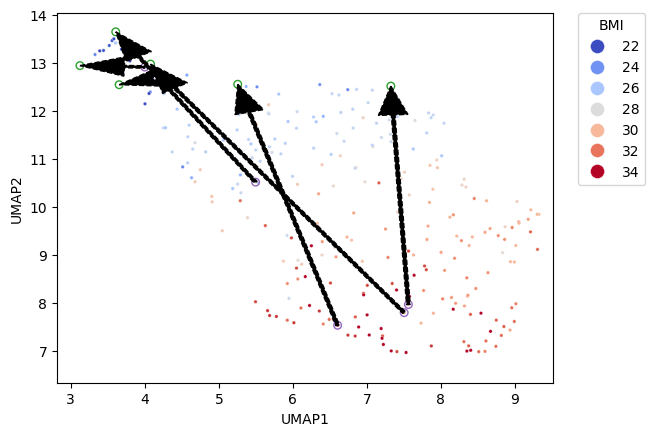

In [34]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, emb_kind=emb_kind,margin_amount=margin_amount,dot_size=100,
                            palette='coolwarm')
# add some text in the corner of the plot
# how to make this text smllar"
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

for row_id in chosen_row_list:
    row = exercise_changes.loc[row_id]
    
    baseline_x = row[(f'{emb_kind}1', 'Baseline')]
    baseline_y = row[(f'{emb_kind}2', 'Baseline')]
    hour_x = row[(f'{emb_kind}1', '1 hour')]
    hour_y = row[(f'{emb_kind}2', '1 hour')]

    # Draw a scatter plot for the 'Baseline' point
    plt.scatter(baseline_x, baseline_y, edgecolor='C4', facecolors='none', s=30)
    
    # Draw a scatter plot for the '1 hour' point
    plt.scatter(hour_x, hour_y, edgecolor='C2', facecolors='none',s=30)
    
    
    plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
        head_width=0.4,width=0.05,linestyle='--')

# plt.xlim(-13,13)
# plt.ylim(-13,13)

plt.xlim(xlims)
plt.ylim(ylims)
plt.savefig(os.path.join(chosen_plots_dir, 'color_top_movement_embedding.png'), dpi=600, bbox_inches='tight')  


Number of samples: 269


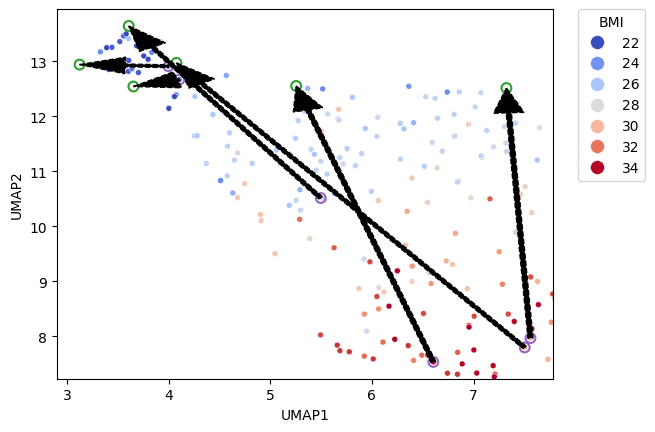

In [35]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, emb_kind=emb_kind,margin_amount=margin_amount,
                           dot_size=300,palette='coolwarm')
# add some text in the corner of the plot
# how to make this text smllar"
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

for row_id in chosen_row_list:
    row = exercise_changes.loc[row_id]
    baseline_x = row[(f'{emb_kind}1', 'Baseline')]
    baseline_y = row[(f'{emb_kind}2', 'Baseline')]
    hour_x = row[(f'{emb_kind}1', '1 hour')]
    hour_y = row[(f'{emb_kind}2', '1 hour')]

    # Draw a scatter plot for the 'Baseline' point
    # plt.scatter(baseline_x, baseline_y, edgecolor='C0', facecolors='none',s=40)
    plt.scatter(baseline_x, baseline_y, edgecolor='C4', facecolors='none',s=50,linewidths=1.5)
    
    # Draw a scatter plot for the '1 hour' point
    plt.scatter(hour_x, hour_y, edgecolor='C2', facecolors='none',s=50,linewidths=1.5)
    
    # Draw an arrow from the 'Baseline' point to the '1 hour' point
    plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
            head_width=0.3,width=0.05,linestyle='--')

plt.xlim(chosen_xlims)
plt.ylim(chosen_ylims)
plt.savefig(os.path.join(chosen_plots_dir, 'color_top_movement_embedding_zoom.png'), dpi=600, bbox_inches='tight')   

Number of samples: 269


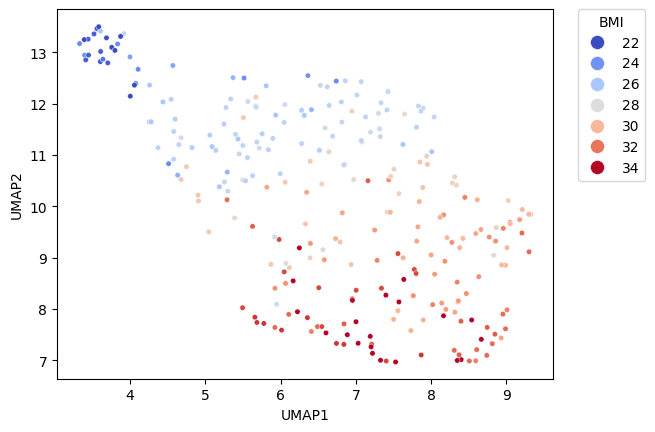

In [36]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, 
                           emb_kind=emb_kind,margin_amount=margin_amount, palette='coolwarm')
# add some text in the corner of the plot
# how to make this text smllar"
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

plt.savefig(os.path.join(chosen_plots_dir, 'bmi_embedding.png'), dpi=600, bbox_inches='tight')

Number of samples: 269


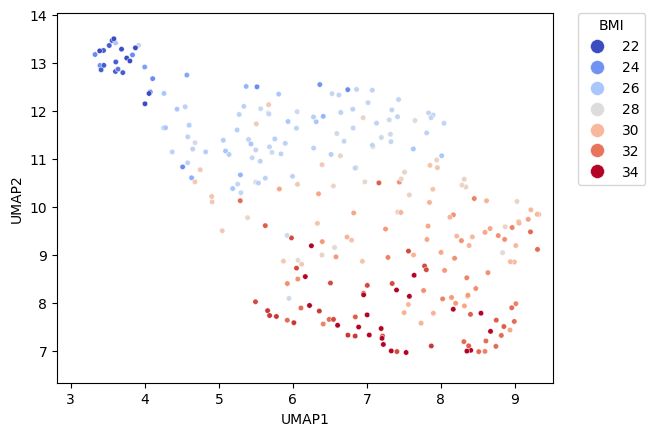

In [37]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, 
                           emb_kind=emb_kind,margin_amount=margin_amount, palette='coolwarm')
# add some text in the corner of the plot
# how to make this text smllar"
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

plt.xlim(xlims)
plt.ylim(ylims)

plt.savefig(os.path.join(chosen_plots_dir, 'bmi_embedding_larger_lims.png'), dpi=600, bbox_inches='tight')

Number of samples: 269


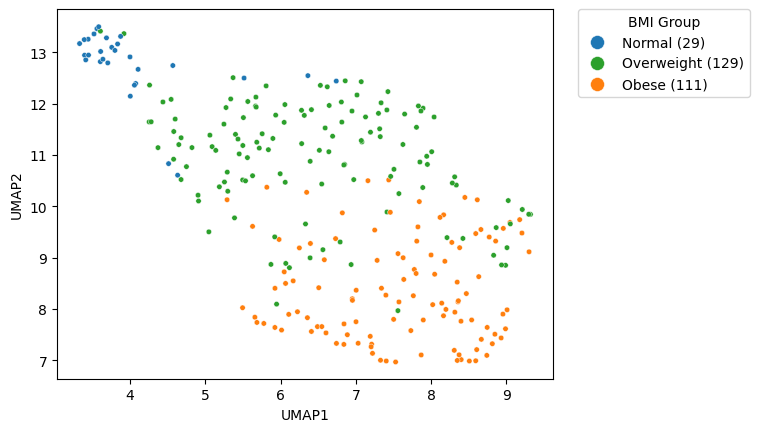

In [38]:
create_nice_embedding_plot(trainval_embedding, 'BMI Group', df, emb_kind=emb_kind,margin_amount=margin_amount)
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

plt.savefig(os.path.join(chosen_plots_dir, 'bmi-group_embedding.png'), dpi=600, bbox_inches='tight')

Number of samples: 269


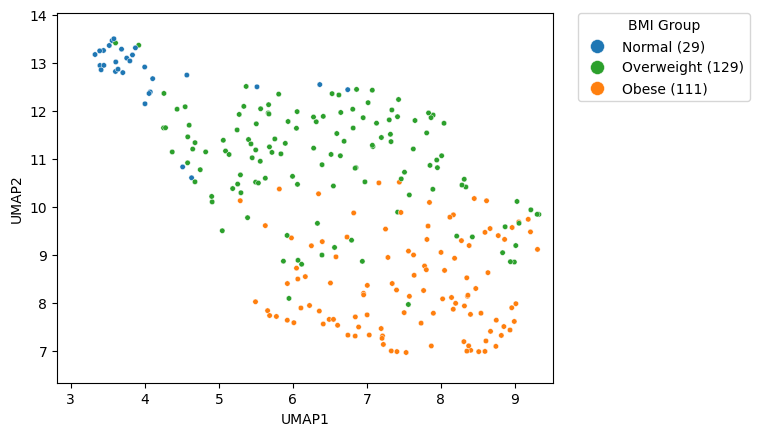

In [39]:
create_nice_embedding_plot(trainval_embedding, 'BMI Group', df, emb_kind=emb_kind,margin_amount=margin_amount)
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

plt.xlim(xlims)
plt.ylim(ylims)
plt.savefig(os.path.join(chosen_plots_dir, 'bmi-group_embedding_largerlims.png'), dpi=600, bbox_inches='tight')

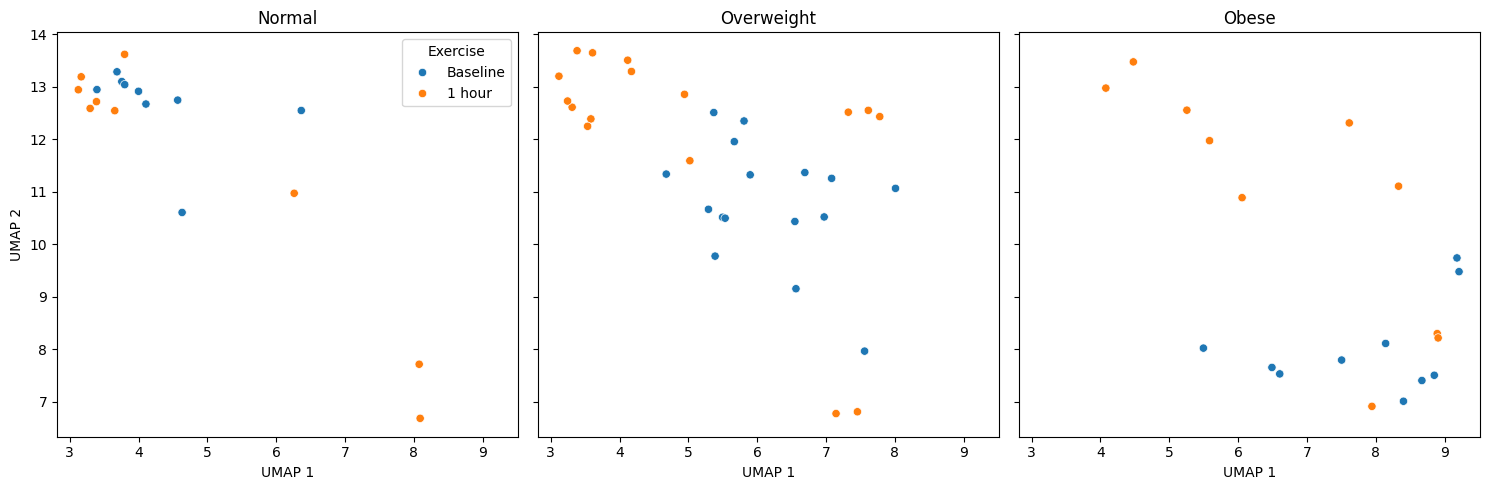

In [40]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Define the labels for the subplots
labels = ['Normal', 'Overweight', 'Obese']

# Iterate over the subplots and plot thef {emb_kind} scatter plot for each group
for i, ax in enumerate(axes):
    # Get the subset of the dataframe for the current group
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    
    # Get thef {emb_kind} embedding values for the subset
#    embedd_values = subset[[f'{emb_kind}1', f'{emb_kind}2']].values
    
    
    # Scatter plot withf {emb_kind} values as x and y coordinates, and event time as color
    # ax.scatterf({emb_kind}_values[:, 0],f {emb_kind}_values[:, 1], c=event_time, cmap='viridis')
    sns.scatterplot(data=subset, x=f'{emb_kind}1', y=f'{emb_kind}2', hue='Exercise', palette='tab10', ax=ax)
    # remove the legend
    if i > 0:
        ax.get_legend().remove()


    
    # Set the title and axis labels for the subplot
    ax.set_title(labels[i])
    ax.set_xlabel(f'{emb_kind} 1')
    ax.set_ylabel(f'{emb_kind} 2')

# Add a colorbar to the last subplot
# cbar = plt.colorbar(ax=axes[-1])
# cbar.set_label('Event Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join(chosen_plots_dir, 'sorted-bmi_embedding.png'), dpi=600, bbox_inches='tight')

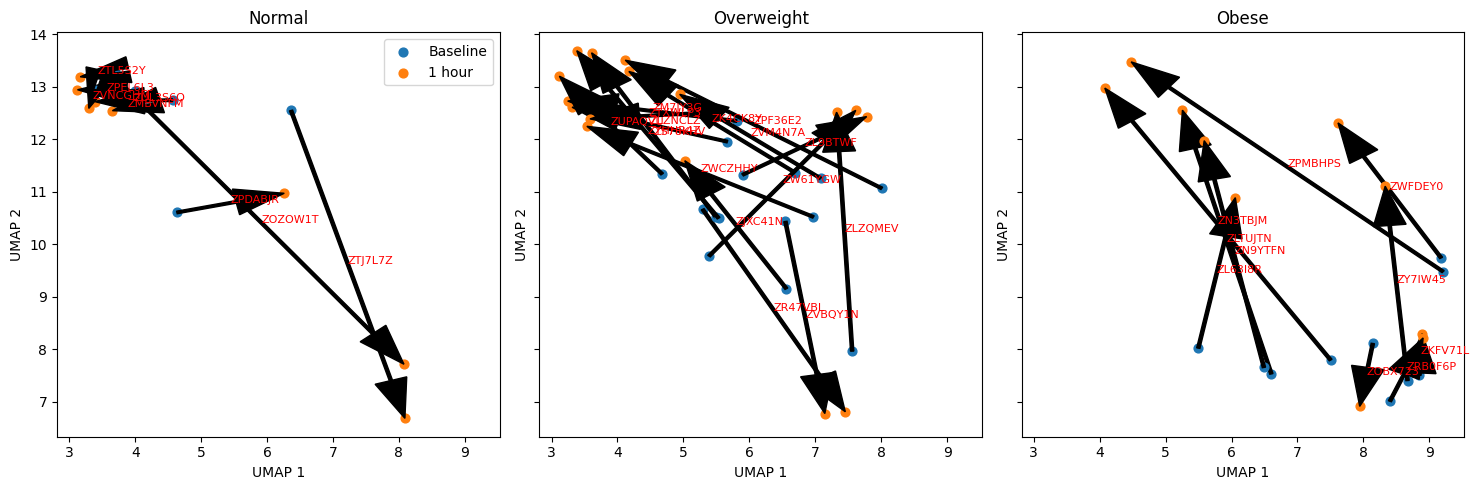

In [42]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Define the labels for the subplots
labels = ['Normal', 'Overweight', 'Obese']

# Iterate over the subplots and plot thef {emb_kind} scatter plot for each group
for i, ax in enumerate(axes):
    # Get the subset of the dataframe for the current group
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    subset = subset.drop_duplicates(subset=['subject ID', 'Event_Note1'])
    matched_subset = subset.pivot(index='subject ID', columns='Event_Note1', values=[f'{emb_kind}1',f'{emb_kind}2'])
    
    for idx, row in matched_subset.iterrows():
        # Get the coordinates for the 'Baseline' and '1 hour' points
        baseline_x = row[(f'{emb_kind}1', 'Baseline')]
        baseline_y = row[(f'{emb_kind}2', 'Baseline')]
        hour_x = row[(f'{emb_kind}1', '1 hour')]
        hour_y = row[(f'{emb_kind}2', '1 hour')]

        # Draw a scatter plot for the 'Baseline' point
        ax.scatter(baseline_x, baseline_y, color='C0', label='Baseline' if idx == matched_subset.index[0] else "", s=40)
        
        # Draw a scatter plot for the '1 hour' point
        ax.scatter(hour_x, hour_y, color='C1', label='1 hour' if idx == matched_subset.index[0] else "", s=40)
        
        # Draw an arrow from the 'Baseline' point to the '1 hour' point
        ax.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
                head_width=0.5,width=0.05,linestyle='-')
        r_dist = np.sqrt((hour_x - baseline_x)**2 + (hour_y - baseline_y)**2)
        
        ax.text((baseline_x + hour_x) / 2, (baseline_y + hour_y) / 2, str(idx), color='red', fontsize=8)


    # add a legend
    if i == 0:
        ax.legend()


    
    # Set the title and axis labels for the subplot
    ax.set_title(labels[i])
    ax.set_xlabel(f'{emb_kind} 1')
    ax.set_ylabel(f'{emb_kind} 2')

# Add a colorbar to the last subplot
# cbar = plt.colorbar(ax=axes[-1])
# cbar.set_label('Event Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join(chosen_plots_dir, 'arrow-bmi_embedding.png'), dpi=600, bbox_inches='tight')

In [30]:
show_text

False

In [31]:
chosen_row_list

['ZPEL6L3', 'ZMBVNFM', 'ZLTUJTN', 'ZN3TBJM', 'ZS78KHV', 'ZLZQMEV']

Number of samples: 269


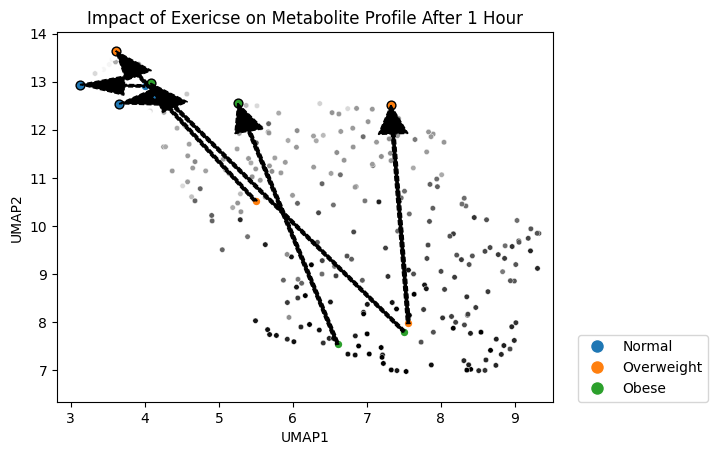

In [43]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, emb_kind=emb_kind,palette='gray_r',margin_amount=margin_amount)
# remove the legend
# plt.gca().get_legend().remove()


legend_text = ['Normal', 'Overweight', 'Obese']
legend_colors = ['C0','C1','C2']
legend_markers = ['o','o','o']
legend_text_to_colors = dict(zip(legend_text, legend_colors))

for row_id in chosen_row_list:
    row = exercise_changes.loc[row_id]
    baseline_x = row[(f'{emb_kind}1', 'Baseline')]
    baseline_y = row[(f'{emb_kind}2', 'Baseline')]
    hour_x = row[(f'{emb_kind}1', '1 hour')]
    hour_y = row[(f'{emb_kind}2', '1 hour')]
    bmi_group = row['BMI Group'].iloc[0]
    facecolors = legend_text_to_colors[bmi_group]

    # Draw a scatter plot for the 'Baseline' point
    plt.scatter(baseline_x, baseline_y, edgecolor='white', facecolors=facecolors,s=40)
    
    # Draw a scatter plot for the '1 hour' point
    plt.scatter(hour_x, hour_y, edgecolor='black', facecolors=facecolors,s=40)
    
    # Draw an arrow from the 'Baseline' point to the '1 hour' point
    plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
            head_width=0.4,width=0.05,linestyle='--')

legend_labels = []
for i in range(3):
    legend_labels.append(f'{labels[i]}')
    # for j in range(2):
    #     legend_labels.append(f'{labels[i]} {["Baseline","1 hour"][j]}')

plt.legend(handles=[plt.Line2D([0], [0], marker=legend_markers[i], color='w',
    markerfacecolor=legend_colors[i], markersize=10, label=legend_text[i]) for i in range(3)],
     loc='lower left',bbox_to_anchor=(1.05, 0), borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Impact of Exericse on Metabolite Profile After 1 Hour')
plt.xlim(xlims)
plt.ylim(ylims)

plt.savefig(os.path.join(chosen_plots_dir, 'gray_top_movement_embedding.png'), dpi=600, bbox_inches='tight')                

Number of samples: 269


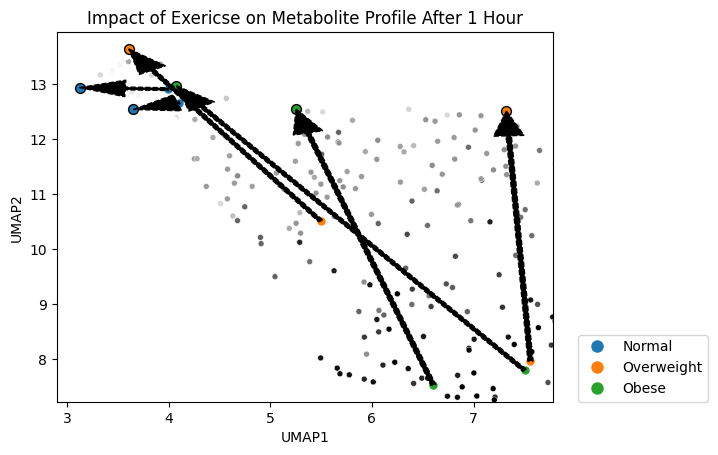

In [44]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, emb_kind=emb_kind,palette='gray_r',dot_size=300)
# remove the legend
# plt.gca().get_legend().remove()

# add some text in the corner of the plot
# how to make this text smllar"
if show_text:
    plt.text(0.98, 0.02, desc_text, 
        verticalalignment='bottom', 
        horizontalalignment='right', 
        transform=plt.gca().transAxes,
        fontsize=6)

legend_text = ['Normal', 'Overweight', 'Obese']
legend_colors = ['C0','C1','C2']
legend_markers = ['o','o','o']
legend_text_to_colors = dict(zip(legend_text, legend_colors))

for row_id in chosen_row_list:
    row = exercise_changes.loc[row_id]
    baseline_x = row[(f'{emb_kind}1', 'Baseline')]
    baseline_y = row[(f'{emb_kind}2', 'Baseline')]
    hour_x = row[(f'{emb_kind}1', '1 hour')]
    hour_y = row[(f'{emb_kind}2', '1 hour')]
    bmi_group = row['BMI Group'].iloc[0]
    facecolors = legend_text_to_colors[bmi_group]

    # Draw a scatter plot for the 'Baseline' point
    plt.scatter(baseline_x, baseline_y, edgecolor='white', facecolors=facecolors,s=50)
    
    # Draw a scatter plot for the '1 hour' point
    plt.scatter(hour_x, hour_y, edgecolor='black', facecolors=facecolors,s=50)
    
    # Draw an arrow from the 'Baseline' point to the '1 hour' point
    plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
            head_width=0.3,width=0.05,linestyle='--')

    # place legend outside of the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)     
# plt.savefig(os.path.join(chosenf_{emb_kind}_plots_dir, 'gray_top_movement_embedding.png'), dpi=600, bbox_inches='tight')  

# add a custom legend to the plot for the Obsese groups
# legend_text = ['Normal Baseline', 'Normal 1 hour', 'Overweight Baseline', 'Overweight 1 hour', 'Obese Baseline', 'Obese 1 hour']
# legend_colors = ['C0','C0','C1','C1','C2','C2']
# legend_markers = ['o','o','o','o','o','o']
legend_text = ['Normal', 'Overweight', 'Obese']
legend_colors = ['C0','C1','C2']
legend_markers = ['o','o','o']


legend_labels = []
for i in range(3):
    legend_labels.append(f'{labels[i]}')
    # for j in range(2):
    #     legend_labels.append(f'{labels[i]} {["Baseline","1 hour"][j]}')
plt.legend(handles=[plt.Line2D([0], [0], marker=legend_markers[i], color='w',
    markerfacecolor=legend_colors[i], markersize=10, label=legend_text[i]) for i in range(3)],
     loc='lower left',bbox_to_anchor=(1.05, 0), borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Impact of Exericse on Metabolite Profile After 1 Hour')
plt.xlim(chosen_xlims)
plt.ylim(chosen_ylims)

plt.savefig(os.path.join(chosen_plots_dir, 'gray_top_movement_embedding_zoom.png'), dpi=600, bbox_inches='tight')     